In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from models.transformers import DecoderOnlyTransformer
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import yaml
import gc
import torch
from torchinfo import summary
import os
import json
import shutil
import wandb
import yaml
from data.datasets import CFGDataset, verify_dataloader
from trainers.GPT_trainer import GPT_Trainer
from trainers.utils import create_optimizer, create_scheduler



device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

#Read config yaml file
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
print(f"Config loaded successfully.")



Using device: cuda
Config loaded successfully.


#### Loading Data

In [ ]:
train_dataset =  CFGDataset(
    data_file="cfg_sentences_train_cfg3b.pkl", 
    batch_size = config["data"]["batch_size"],
    seq_len = config["data"]["seq_len"],
    eos_token = config["data"]["eos_token"],
    sos_token = config["data"]["sos_token"],
    ) 

val_dataset =  CFGDataset(
    data_file="cfg_sentences_val_cfg3b.pkl", 
    
    batch_size = config["data"]["batch_size"],
    seq_len = config["data"]["seq_len"],
    eos_token = config["data"]["eos_token"],
    sos_token = config["data"]["sos_token"],
    ) 


train_loader = DataLoader(train_dataset, 
                          batch_size = None, 
                          num_workers=config["data"]["NUM_WORKERS"] if device == "cuda" else 0, 
                          pin_memory=True)

val_loader = DataLoader(val_dataset, 
                        batch_size=None, 
                        num_workers=config["data"]["NUM_WORKERS"] if device == "cuda" else 0,
                        pin_memory=True)

mb = train_dataset.sequences.element_size() * train_dataset.sequences.nelement() / 1024**2
print(f"Memory size train ~= {mb:.1f} MB")
verify_dataloader(train_loader)
#print("="*50)
#print("Verify Validation DataLoader")
#verify_dataloader(val_loader)

[3 2 3 1 2 1 3 1 2 2 1 1 2 3 3 2 3 1 3 2 1 3 2 1 3 1 3 1 2 1 2 3 2 1 3 2 2
 1 3 2 1 2 3 3 2 1 2 3 2 1 3 2 1 3 1 3 1 2 3 2 1 3 1 3 1 2 3 1 3 1 2 2 1 3
 2 1 3 1 2 3 1 1 2 3 3 1 2 2 1 3 1 3 2 1 3 2 3 2 1 3 1 3 2 3 1 2 3 2 1 3 1
 1 2 3 3 1 2 3 2 1 1 2 3 2 1 3 1 2 3 1 2 3 1 3 2 1 3 1 2 2 1 3 1 3 2 1 1 2
 3 3 1 2 3 1 2 3 1 3 2 1 3 2 3 1 3 2 1 3 2 3 2 1 1 2 3 3 1 3 2 1 3 2 1 2 3
 3 1 2 2 1 3 1 2 2 1 3 1 2 1 3 1 2 1 2 3 3 1 2 2 1 1 2 3 3 1 2 3 1 3 2 1 3
 2 1 3 1 2 3 1 3 1 3 1 2 3 2 1 2 1 1 2 3 3 1 2 3 2 1 3 1 3 1 2 3 2 3 1 3 2
 1 1 2 3 3 2 2 1 3 2 1 3 1 3 2 2 1 3 2 1 2 3]
len data 720000
[3 2 3 2 1 1 2 3 3 1 2 3 1 2 1 2 1 3 1 2 3 1 3 2 1 2 3 3 2 1 2 1 1 2 3 3 2
 1 2 3 2 1 3 2 3 1 2 1 2 3 3 2 1 3 2 1 1 2 3 3 2 3 2 1 1 2 3 3 2 3 1 3 1 2
 3 2 1 1 2 3 3 2 2 1 1 2 3 2 1 3 2 3 2 1 3 1 3 1 2 3 1 3 2 2 1 3 2 2 1 3 1
 2 1 1 2 3 3 2 1 2 3 3 2 2 1 3 1 3 2 1 3 1 2 3 1 2 3 2 1 1 2 3 1 2 3 3 2 3
 2 1 3 2 3 2 1 3 1 3 2 1 2 3 2 1 2 1 3 1 2 1 2 3 3 1 3 2 1 3 2 1 2 3 3 1 2
 3 2 1 3 1 2 3 2 1 1 2 3 1 2 3 2 1 3 2

In [3]:
model_config = {}
model_config = config['model'].copy()

model_config.update({
    'num_classes': config["data"]["vocab_size"] +2 ,#include SOS and ESO tolen
    'seq_len': config["data"]["seq_len"],
    })

model = DecoderOnlyTransformer(**model_config)

for batch in train_loader:
    shifted_transcripts, golden_transcripts = batch
    print("Shape of shifted_transcripts : ", shifted_transcripts.shape)
    print("Shape of golden_transcripts  : ", golden_transcripts.shape)
    break

#model_stats = summary(model, input_data=[shifted_transcripts])
#print(model_stats)
print("Total parameters in the model : ", sum(p.numel() for p in model.parameters()))

Shape of shifted_transcripts :  torch.Size([256, 512])
Shape of golden_transcripts  :  torch.Size([256, 512])
Total parameters in the model :  85063685


In [ ]:
#get total memory space used by data
#total_memory = torch.cuda.memory_allocated(device) / (1024 ** 3)
#print(f"Total memory used by data: {total_memory:.2f} GB")

In [ ]:
torch.cuda.empty_cache()
gc.collect()

trainer = GPT_Trainer(
    model = model, 
    config = config,
    config_file = "config.yaml",
    run_name = "test", 
    device = device
)

Using device: cuda


flattened_seq_tensor ~= 1525.0 MB



🔧 Configuring Optimizer:
├── Type: ADAMW
├── Base LR: 0.0006
├── Weight Decay: 0.1
├── Parameter Groups:
│   ├── Group: self_attn
│   │   ├── LR: 0.0007
│   │   └── Patterns: []
│   ├── Group: ffn
│   │   ├── LR: 0.0007
│   │   └── Patterns: []
│   └── Default Group (unmatched parameters)
└── AdamW Specific:
    ├── Betas: [0.9, 0.98]
    ├── Epsilon: 1e-08
    └── AMSGrad: False


/jet/home/sfragara/.conda/envs/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



📈 Configuring Learning Rate Scheduler:
├── Type: COSINE
├── Cosine Annealing Settings:
│   ├── T_max: 1525 steps
│   └── Min LR: 1e-08
├── Warmup Settings:
│   ├── Duration: 5 epochs (7625 steps)
│   ├── Start Factor: 0.1
│   └── End Factor: 1.0


/jet/home/sfragara/.conda/envs/env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


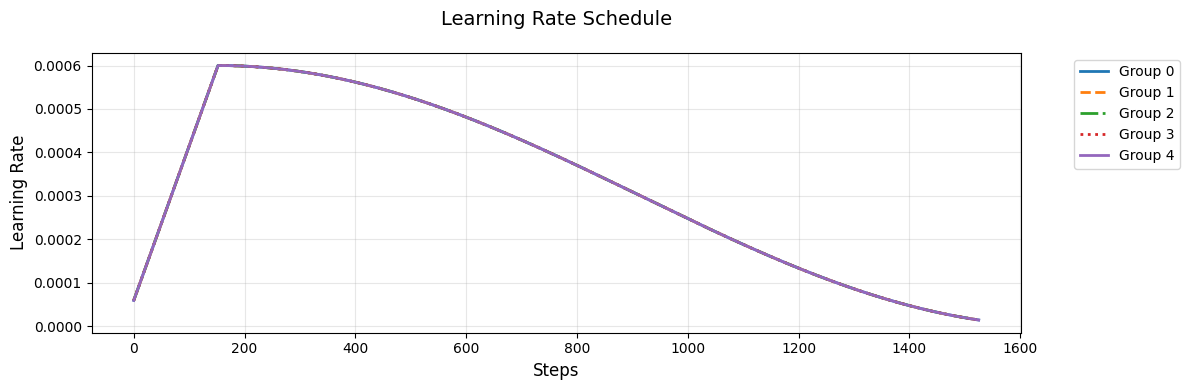

In [5]:
trainer.optimizer = create_optimizer.create_optimizer(
    model = model, 
    opt_config = config["optimizer"]
)

trainer.scheduler = create_scheduler.create_scheduler(
    optimizer=trainer.optimizer,
    scheduler_config=config['scheduler'],
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)


create_scheduler.plot_lr_schedule(
    scheduler=trainer.scheduler,
    num_epochs=len(train_loader),
    train_loader=train_loader,
    gradient_accumulation_steps=config['training']['gradient_accumulation_steps']
)


In [6]:
trainer.train_epoch(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
)

[Training LM]:   0%|                                                         | 0/1525 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 576.00 MiB. GPU 0 has a total capacty of 79.21 GiB of which 154.75 MiB is free. Including non-PyTorch memory, this process has 78.88 GiB memory in use. Of the allocated memory 77.19 GiB is allocated by PyTorch, and 1.03 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF